
# Declustering in Python with PyGSLIB / GeostatPy for Engineers and Geoscientists 
### Michael Pyrcz, Associate Professor, University of Texas at Austin 

#### Contacts: [Twitter/@GeostatsGuy](https://twitter.com/geostatsguy) | [GitHub/GeostatsGuy](https://github.com/GeostatsGuy) | [www.michaelpyrcz.com](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446)

This is a tutorial for / demonstration of **spatial declustering in Python** with the PyGSLIB package (by Adrian Martinez Vargas) that wraps some of the FORTRAN algorithms from GSLIB, Geostatistical Library (Deutsch and Journel, 1997).  The GeostatPy (by Michael Pyrcz) is an informal collection of Python programs that write parameter files, data files, run GSLIB executables and then read results back. There has been some reimplimentation of visualization with MatPlotLib methods. 

Cell-based declustering is available in the declus algorithm from GSLIB. The methods is written about in the GSLIB book (Deutsch and Journel, 1998) and other textbooks such as Pyrcz and Deutsch (2014).  The method provides declustering weights that acocunt for spatial clustering of the data samples.  It is not sensitive to data boundaries, but relies on a cell size assumption. The common method is to attempt a range of cell sizes and retain that one that minimizes the declustered mean if locations with high values have been over sampled (and visa versa).

We will demonstration calculation of declustering weights on regular and irregular spaced data.  

This exercise demonstrates the cell-based declustering approach in Python with wrappers and reimplimentation of GSLIB methods.  The steps include:

1. generate a 2D sequential Guassian simulation using a wrapper of GSLIB's sgsim method
2. extract regular and irregular sample sets from the exhaustive realization
4. run cell-based declustering
5. visualize the declustering weights at the data locations
6. visualize the declustered mean vs. cell size used to determine the optimal cell size

To accomplish this I have provided wrappers or reimplementation in Python for the following GSLIB methods:

1. sgsim - sequantial Gaussian simulation limited to 2D and unconditional
2. hist - histograms plots reimplemented with GSLIB parameters using python methods
3. locmap - location maps reimplemented with GSLIB parameters using python methods
4. pixelplt - pixel plots reimplemented with GSLIB parameters using python methods
5. locpix - my modification of GSLIB to superimpose a location map on a pixel plot reimplemented with GSLIB parameters using Python methods
6. affine - affine correction adjust the mean and standard deviation of a feature reimplemented with GSLIB parameters using Python methods
7. nscore - normal score transform (data transformation to Gaussian with a mean of zero and a standard deviation of one)

These methods are all in the functions declared upfront. To run this demo all one has to do is download and place in your working directory the following executables from the GSLIB/bin directory:

1. sgsim.exe
2. declus.exe
3. nscore.exe

The GSLIB source and executables are available at http://www.statios.com/Quick/gslib.html.  For the reference on using GSLIB check out the User Guide, GSLIB: Geostatistical Software Library and User's Guide by Clayton V. Deutsch and Andre G. Journel.

I did this to try out the PyGSLIB package in Python.  I created GeostatPy functions to allow people to use these GSLIB functions that are extremely robust in Python. Also this should be a bridge to allow so many familar with GSLIB to work in Python as a kept the parameterization and displays consistent with GSLIB.  The wrappers are simple functions declared below that write the parameter files, run the GSLIB executable in the working directory and load and visualize the output in Python. This will be included on GitHub for anyone to try it out https://github.com/GeostatsGuy/.  

I used this tutorial in my Introduction to Geostatistics undergraduate class (PGE337 at UT Austin) as part of a first introduction to geostatistics and Python for the engineering undergraduate students. It is assumed that students have no previous Python, geostatistics nor machine learning experience; therefore, all steps of the code and workflow are explored and described. This tutorial is augmented with course notes in my class.  The Python code and markdown was developed and tested in Jupyter. 

#### Load the required libraries

The following code loads the required libraries.



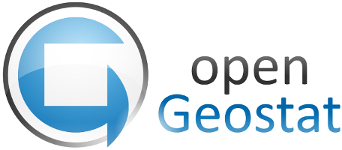

In [2]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
import pygslib as gslib

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare functions

Here are the wrappers and reimplementations of GSLIB method along with 4 utilities to move between GSLIB's Geo-EAS data sets and DataFrames, and grids and 2D Numpy arrays respectively and 2 utilities to resample from regular datasets.  Available GSLIB functions include:

1. hist
2. pixelplt
3. locmap
4. locpix
5. vargplt
6. affine
7. nscore
8. declus
9. gam
10. gamv
11. vmodel
12. sgsim

For now we embed the functions in the workflow below. In the future this will be turned into a proper Python package.  Warning, there has been no attempt to make these functions robust in the precense of bad inputs.  If you get a crazy error check the inputs.  Are the arrays empty and are they the same size when they should be?  Are the arrays the correct dimension?  Is the parameter order mixed up?  Make sure the inputs are consistent with the descriptions in this document.

In [3]:
# utility to convert GSLIB Geo-EAS files to a pandas DataFrame for use with Python methods
def GSLIB2Dataframe(data_file):
    import os
    import numpy as np  
    import pandas as pd

    colArray = []
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])
        for icol in range(0, ncol):
            head = [next(myfile) for x in range(1)]
            colArray.append(head[0].split()[0])
        data = np.loadtxt(myfile, skiprows = 0)
        df = pd.DataFrame(data)
        df.columns = colArray
        return df

# utility to convert pandas DataFrame to a GSLIB Geo-EAS file for use with GSLIB methods
def Dataframe2GSLIB(data_file,df):
    colArray = []
    colArray = df.columns
    ncol = len(df.columns) 
    nrow = len(df.index)
    file_out = open(data_file, "w")
    file_out.write(data_file + '\n')  
    file_out.write(str(ncol) + '\n') 
    for icol in range(0, ncol): 
        file_out.write(df.columns[icol]  + '\n')  
    
    for irow in range(0, nrow):
        for icol in range(0, ncol):
            file_out.write(str(df.iloc[irow,icol])+ ' ')  
        file_out.write('\n')

    file_out.close()       

# utility to convert GSLIB Geo-EAS files to a numpy ndarray for use with Python methods
def GSLIB2ndarray(data_file,kcol,nx,ny):
    import os
    import numpy as np  

    colArray = []
    if ny > 1:
        array = np.ndarray(shape=(ny,nx),dtype=float,order='F')
    else:
        array = np.zeros(nx)
        
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])          # get the number of columns
        for icol in range(0, ncol):   # read over the column names
            head = [next(myfile) for x in range(1)]
            if icol == kcol:
                col_name = head[0].split()[0]
        for iy in range(0,ny):
            for ix in range(0,nx):
                head = [next(myfile) for x in range(1)]
                array[ny-1-iy][ix] = head[0].split()[kcol]
    return array,col_name

# utility to convert numpy ndarray to a GSLIB Geo-EAS file for use with GSLIB methods   
def ndarray2GSLIB(array,data_file,col_name):
    file_out = open(data_file, "w")
    file_out.write(data_file + '\n')  
    file_out.write('1 \n')  
    file_out.write(col_name  + '\n') 
    if array.ndim == 2:
        ny = (array.shape[0])
        nx = (array.shape[1])
        ncol = 1
        for iy in range(0, ny):
            for ix in range(0, nx):
                file_out.write(str(array[ny-1-iy,ix])+ '\n')        
    elif array.ndim == 1:
        nx = len(array)        
        for ix in range(0, nx):
            file_out.write(str(array[ix])+ '\n')             
    else:       
        Print("Error: must use a 2D array")            
        file_out.close()
        return            
    file_out.close()
    
# histogram, reimplemented in Python of GSLIB hist with MatPlotLib methods
def hist(array,xmin,xmax,log,cumul,bins,weights,xlabel,title):
    plt.figure(figsize=(8,6))
    cs = plt.hist(array, alpha = 0.2, color = 'red', edgecolor = 'black', bins=bins, range = [xmin,xmax], weights = weights, log = log, cumulative = cumul)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel('Frequency')    
    plt.show()
    return
   
# pixel plot, reimplemention in Python of GSLIB pixelplt with MatPlotLib methods
def pixelplt(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    plt.figure(figsize=(8,6))
    im = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels=np.linspace(vmin,vmax,100))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im,orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.show()
    return im

# location map, reimplemention in Python of GSLIB locmap with MatPlotLib methods
def locmap(df,xcol,ycol,vcol,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    ixy = 0 
    plt.figure(figsize=(8,6))    
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.show()
    return im

def vargplt(lag,gamma,npair,vtype,name,xmin,xmax,ymin,ymax,sill,title,cmap):
    plt.figure(figsize=(8,6))
    marker = ["o","v","s","h","^",">","<"]
    if vtype==0:
        im = plt.scatter(lag,gamma,s=None, c=npair, marker=None, label = name,cmap=cmap, norm=None, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    else:
        plt.plot(lag,gamma,'C3',lw=3,c='black')
    ixy = 0 
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel('Lag Distance (m)')
    plt.ylabel('Variogram')
    plt.arrow(0,sill,xmax,0,width=0.002,color='red',head_length=0.0,head_width=0.0)
    plt.legend(loc = 'lower right')
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label('Number of Pairs', rotation=270, labelpad=20)
    plt.show()
    return im

def vargplts(lag,gamma,npair,vtype,name,xmin,xmax,ymin,ymax,sill,title,cmap):
    plt.figure(figsize=(8,6))
    marker = ["o","v","s","h","^",">","<"]
    nvar = lags.shape[0]
    for ivar in range(0, nvar):
        if vtype[ivar]==0:
            im = plt.scatter(lag[ivar],gamma[ivar],s=None,label = name[ivar],c=npair[ivar], marker=marker[ivar], cmap=cmap, norm=None, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
        else:
            plt.plot(lag[ivar],gamma[ivar], 'C3', lw=3,c='black')
    ixy = 0 
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel('Lag Distance (m)')
    plt.ylabel('Variogram')
    plt.arrow(0,sill,xmax,0,width=0.002,color='red',head_length=0.0,head_width=0.0)
    plt.legend(loc = 'lower right')
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label('Number of Pairs', rotation=270, labelpad=20)
    plt.show()
    return im

# pixelplt with location map superimposed, reimplementation in Python of a MOD from GSLIB with MatPlotLib methods
def locpix(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step)) 
    plt.figure(figsize=(8,6))
    cs = plt.contourf(xx, yy, array, cmap=cmap,vmin=vmin, vmax=vmax, levels=np.linspace(vmin,vmax,100))
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.xlim(xmin,xmax-step)
    plt.ylim(ymin+step,ymax) 
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.show()
    return cs

# affine distribution correction reimplemented in Python with numpy methods 
def affine(array,tmean,tstdev):    
    if array.ndim != 2:
        Print("Error: must use a 2D array")
        return
    nx = array.shape[0]
    ny = array.shape[1]
    mean = np.average(array)
    stdev = np.std(array)
    for iy in range(0,ny):
        for ix in range(0,nx):
             array[ix,iy]= (tstdev/stdev)*(array[ix,iy] - mean) + tmean  
    return(array)            

# normal score transform, wrapper for nscore from GSLIB (.exe must be in working directory)(not used in this demo)   
def nscore(x):
    import os
    import numpy as np
    file = 'nscore_out.dat'
    ndarray2GSLIB(x,"nscore.dat","value")
    
    file = open("nscore.par", "w")
    file.write("                  Parameters for NSCORE                                    \n")
    file.write("                  *********************                                    \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("nscore.dat           -file with data                                       \n")
    file.write("1   0                    -  columns for variable and weight                \n")
    file.write("-1.0e21   1.0e21         -  trimming limits                                \n")
    file.write("0                        -1=transform according to specified ref. dist.    \n")
    file.write("../histsmth/histsmth.out -  file with reference dist.                      \n")
    file.write("1   2                    -  columns for variable and weight                \n")
    file.write("nscore.out               -file for output                                  \n")
    file.write("nscore.trn               -file for output transformation table             \n")
    file.close()

    os.system('nscore.exe nscore.par')
    file_in = 'nscore.out'
    y,name = GSLIB2ndarray('nscore.out',1,nx,ny)
    return(y)

# cell-based declustering, 2D wrapper for declus from GSLIB (.exe must be in working directory)
def declus(df,xcol,ycol,vcol,cmin,cmax,cnum,bmin):
    import os
    import numpy as np
    nrow = len(df)
    weights = []
    file = 'declus_out.dat'
    file_out = open(file, "w")
    file_out.write('declus_out.dat' + '\n')  
    file_out.write('3' + '\n')  
    file_out.write('x' + '\n') 
    file_out.write('y' + '\n')
    file_out.write('value' + '\n')  
    for irow in range(0, nrow):
        file_out.write(str(df.iloc[irow][xcol])+' '+str(df.iloc[irow][ycol])+' '+str(df.iloc[irow][vcol])+' \n')        
    file_out.close()
    
    file = open("declus.par", "w")
    file.write("                  Parameters for DECLUS                                    \n")
    file.write("                  *********************                                    \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("declus_out.dat           -file with data                                   \n")
    file.write("1   2   0   3               -  columns for X, Y, Z, and variable           \n")
    file.write("-1.0e21     1.0e21          -  trimming limits                             \n")
    file.write("declus.sum                  -file for summary output                       \n") 
    file.write("declus.out                  -file for output with data & weights           \n")
    file.write("1.0   1.0                   -Y and Z cell anisotropy (Ysize=size*Yanis)    \n") 
    file.write(str(bmin) + "                -0=look for minimum declustered mean (1=max)   \n") 
    file.write(str(cnum) + " " + str(cmin) + " " + str(cmax) + " -number of cell sizes, min size, max size      \n")
    file.write("5                           -number of origin offsets                      \n")
    file.close()
    
    os.system('declus.exe declus.par')
    df = GSLIB2Dataframe("declus.out")
    for irow in range(0, nrow):
        weights.append(df.iloc[irow,3])    

    return(weights)
 
# regular grid variogram, 2D wrapper for gam from GSLIB (.exe must be in working directory)
def gam_2d(array,nx,ny,hsiz,nlag,xlag,ylag,bstand):
    import os
    import numpy as np
    
    lag = []; gamma = []; npair = []
    
    ndarray2GSLIB(array,"gam_out.dat","gam.dat")
    
    file = open("gam.par", "w")
    file.write("                  Parameters for GAM                                       \n")
    file.write("                  ******************                                       \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("gam_out.dat           -file with data                                      \n")
    file.write("1   1   0             -   number of variables, column numbers              \n")
    file.write("-1.0e21     1.0e21    -   trimming limits                                  \n")
    file.write("gam.out               -file for variogram output                           \n")
    file.write("1                     -grid or realization number                          \n")
    file.write(str(nx) + " 0.0 " + str(hsiz) + "  -nx, xmn, xsiz                           \n")
    file.write(str(ny) + " 0.0 " + str(hsiz) + "  -ny, ymn, ysiz                           \n")
    file.write(" 1   0.5   1.0        -nz, zmn, zsiz                                       \n")
    file.write("1 " + str(nlag) + "   -number of directions, number of lags                \n")
    file.write(str(xlag) + " " + str(ylag) + " 0 -ixd(1),iyd(1),izd(1)                     \n")
    file.write("1                     -standardize sill? (0=no, 1=yes)                     \n")
    file.write("1                     -number of variograms                                \n")
    file.write("1   1   1             -tail variable, head variable, variogram type        \n") 
    file.close()
    
    os.system('gam.exe gam.par')
    reading = True
    with open("gam.out") as myfile:   
        head = [next(myfile) for x in range(1)] # skip the first line
        iline = 0
        while reading:
            try:
                head = [next(myfile) for x in range(1)]
                lag.append(float(head[0].split()[1]))
                gamma.append(float(head[0].split()[2]))
                npair.append(float(head[0].split()[3]))
                iline = iline + 1
            except StopIteration:
                reading = False   
    
    return(lag,gamma,npair)    

# regular grid variogram, 2D wrapper for gam from GSLIB (.exe must be in working directory)
def gamv_2d(df,xcol,ycol,vcol,nlag,lagdist,azi,atol,bstand):
    import os
    import numpy as np
    
    lag = []; gamma = []; npair = []
    
    df_ext = pd.DataFrame({'X':df[xcol],'Y':df[ycol],'Z':rand_sample[vcol]})
    Dataframe2GSLIB("gamv_out.dat",df_ext)
    
    file = open("gamv.par", "w")
    
    file.write("                  Parameters for GAMV                                      \n")
    file.write("                  *******************                                      \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("gamv_out.dat                    -file with data                            \n") 
    file.write("1   2   0                         -   columns for X, Y, Z coordinates      \n")
    file.write("1   3   0                         -   number of variables,col numbers      \n")
    file.write("-1.0e21     1.0e21                -   trimming limits                      \n")
    file.write("gamv.out                          -file for variogram output               \n")
    file.write(str(nlag) + "                      -number of lags                          \n")
    file.write(str(lagdist) + "                       -lag separation distance                 \n")
    file.write(str(lagdist*0.5) + "                   -lag tolerance                           \n")
    file.write("1                                 -number of directions                    \n")
    file.write(str(azi) + " " + str(atol) + " 99999.9 0.0  90.0  50.0  -azm,atol,bandh,dip,dtol,bandv \n")
    file.write(str(bstand) + "                    -standardize sills? (0=no, 1=yes)        \n")
    file.write("1                                 -number of variograms                    \n")
    file.write("1   1   1                         -tail var., head var., variogram type    \n")
    file.close()
    
    os.system('gamv.exe gamv.par')
    reading = True
    with open("gamv.out") as myfile:   
        head = [next(myfile) for x in range(1)] # skip the first line
        iline = 0
        while reading:
            try:
                head = [next(myfile) for x in range(1)]
                lag.append(float(head[0].split()[1]))
                gamma.append(float(head[0].split()[2]))
                npair.append(float(head[0].split()[3]))
                iline = iline + 1
            except StopIteration:
                reading = False   
    
    return(lag,gamma,npair)    

# irregular spaced data, 2D wrapper for varmap from GSLIB (.exe must be in working directory)
def varmapv_2d(df,xcol,ycol,vcol,nx,ny,lagdist,minpairs,vmax,bstand,title,vlabel):
    import os
    import numpy as np
    
    lag = []; gamma = []; npair = []
    
    df_ext = pd.DataFrame({'X':df[xcol],'Y':df[ycol],'Z':rand_sample[vcol]})
    Dataframe2GSLIB("varmap_out.dat",df_ext)
    
    file = open("varmap.par", "w")
    
    file.write("              Parameters for VARMAP                                        \n")
    file.write("              *********************                                        \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("varmap_out.dat          -file with data                                    \n")
    file.write("1   3                        -   number of variables: column numbers       \n")
    file.write("-1.0e21     1.0e21           -   trimming limits                           \n")
    file.write("0                            -1=regular grid, 0=scattered values           \n")
    file.write(" 50   50    1                -if =1: nx,     ny,   nz                      \n")
    file.write("1.0  1.0  1.0                -       xsiz, ysiz, zsiz                      \n") 
    file.write("1   2   0                    -if =0: columns for x,y, z coordinates        \n") 
    file.write("varmap.out                   -file for variogram output                    \n")
    file.write(str(nx) + " " + str(ny) + " 0 " + "-nxlag, nylag, nzlag                     \n")
    file.write(str(lagdist) + " " + str(lagdist) + " 1.0              -dxlag, dylag, dzlag \n")
    file.write(str(minpairs) + "             -minimum number of pairs                      \n")
    file.write(str(bstand) + "               -standardize sill? (0=no, 1=yes)              \n")
    file.write("1                            -number of variograms                         \n") 
    file.write("1   1   1                    -tail, head, variogram type                   \n")
    file.close()
    
    os.system('varmap.exe varmap.par')
    nnx = nx*2+1; nny = ny*2+1
    varmap, name = GSLIB2ndarray("varmap.out",0,nnx,nny)               
          
    xmax = ((float(nx)+0.5)*lagdist); xmin = -1*xmax; 
    ymax = ((float(ny)+0.5)*lagdist); ymin = -1*ymax; 
    pixelplt(varmap,xmin,xmax,ymin,ymax,lagdist,0,vmax,title,'X','Y',vlabel,cmap)
    return(varmap)  

# regular spaced data, 2D wrapper for varmap from GSLIB (.exe must be in working directory)
def varmap_2d(array,nx,ny,hsiz,nlagx,nlagy,minpairs,vmax,bstand,title,vlabel):
    import os
    import numpy as np
     
    ndarray2GSLIB(array,"varmap_out.dat","gam.dat")
    
    file = open("varmap.par", "w")
    
    file.write("              Parameters for VARMAP                                        \n")
    file.write("              *********************                                        \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("varmap_out.dat          -file with data                                    \n")
    file.write("1   1                        -   number of variables: column numbers       \n")
    file.write("-1.0e21     1.0e21           -   trimming limits                           \n")
    file.write("1                            -1=regular grid, 0=scattered values           \n")
    file.write(str(nx) + " " + str(ny) + " 1  -if =1: nx,     ny,   nz                     \n")
    file.write(str(hsiz) + " " + str(hsiz) + " 1.0  - xsiz, ysiz, zsiz                     \n") 
    file.write("1   2   0                    -if =0: columns for x,y, z coordinates        \n") 
    file.write("varmap.out                   -file for variogram output                    \n")
    file.write(str(nlagx) + " " + str(nlagy) + " 0 " + "-nxlag, nylag, nzlag               \n")
    file.write(str(hsiz) + " " + str(hsiz) + " 1.0              -dxlag, dylag, dzlag       \n")
    file.write(str(minpairs) + "             -minimum number of pairs                      \n")
    file.write(str(bstand) + "               -standardize sill? (0=no, 1=yes)              \n")
    file.write("1                            -number of variograms                         \n") 
    file.write("1   1   1                    -tail, head, variogram type                   \n")
    file.close()
    
    os.system('varmap.exe varmap.par')
    nnx = nlagx*2+1; nny = nlagy*2+1
    varmap, name = GSLIB2ndarray("varmap.out",0,nnx,nny)               
          
    xmax = ((float(nlagx)+0.5)*hsiz); xmin = -1*xmax; 
    ymax = ((float(nlagy)+0.5)*hsiz); ymin = -1*ymax; 
    pixelplt(varmap,xmin,xmax,ymin,ymax,hsiz,0,vmax,title,'X','Y',vlabel,cmap)
    return(varmap)  

# variogram model, 2D wrapper for vmodel from GSLIB (.exe must be in working directory)
def vmodel_2d(nlag,step,azi,nug,nst,tstr1,c1,azi1,rmaj1,rmin1,tstr2=1,c2=0,azi2=0,rmaj2=0,rmin2=0):
    import os
    import numpy as np

    lag = []; gamma = []
    
    file = open("vmodel.par", "w")
    file.write("                                                                           \n")
    file.write("                  Parameters for VMODEL                                    \n")
    file.write("                  *********************                                    \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("vmodel.var                   -file for variogram output                    \n")
    file.write("1 " + str(nlag) + "          -number of directions and lags                \n")
    file.write(str(azi) + " 0.0 " + str(step) + " -azm, dip, lag distance                  \n")
    file.write(str(nst) + " " + str(nug) + " -nst, nugget effect                           \n")
    file.write(str(tstr1) + " " + str(c1) + " " + str(azi1) + " 0.0   0.0   0.0 -it,cc,ang1,ang2,ang3 \n")
    file.write(str(rmaj1) + " " + str(rmin1) + " 0.0 -a_hmax, a_hmin, a_vert               \n")
    file.write(str(tstr2) + " " + str(c2) + " " + str(azi2) + " 0.0   0.0   0.0 -it,cc,ang1,ang2,ang3 \n")
    file.write(str(rmaj2) + " " + str(rmin2) + " 0.0 -a_hmax, a_hmin, a_vert               \n")
    file.close()
    
    os.system('vmodel.exe vmodel.par')
    reading = True
    with open("vmodel.var") as myfile:   
        head = [next(myfile) for x in range(1)] # skip the first line
        iline = 0
        while reading:
            try:
                head = [next(myfile) for x in range(1)]
                lag.append(float(head[0].split()[1]))
                gamma.append(float(head[0].split()[2]))
                iline = iline + 1
            except StopIteration:
                reading = False   
    
    return(lag,gamma)               
               
# sequential Gaussian simulation, 2D unconditional wrapper for sgsim from GSLIB (.exe must be in working directory)
def GSLIB_sgsim_2d_uncond(nreal,nx,ny,hsiz,seed,hrange1,hrange2,azi,output_file):
    import os
    import numpy as np 
    
    hmn = hsiz * 0.5   
    hctab = int(hrange1/hsiz)*2 + 1
    
    sim_array = np.random.rand(nx,ny)
  
    file = open("sgsim.par", "w")
    file.write("              Parameters for SGSIM                                         \n")
    file.write("              ********************                                         \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETER:                                                        \n")
    file.write("none                          -file with data                              \n")
    file.write("1  2  0  3  5  0              -  columns for X,Y,Z,vr,wt,sec.var.          \n")
    file.write("-1.0e21 1.0e21                -  trimming limits                           \n")
    file.write("0                             -transform the data (0=no, 1=yes)            \n")
    file.write("none.trn                      -  file for output trans table               \n")
    file.write("1                             -  consider ref. dist (0=no, 1=yes)          \n")
    file.write("none.dat                      -  file with ref. dist distribution          \n")
    file.write("1  0                          -  columns for vr and wt                     \n")
    file.write("-4.0    4.0                   -  zmin,zmax(tail extrapolation)             \n")
    file.write("1      -4.0                   -  lower tail option, parameter              \n")
    file.write("1       4.0                   -  upper tail option, parameter              \n")
    file.write("0                             -debugging level: 0,1,2,3                    \n")
    file.write("nonw.dbg                      -file for debugging output                   \n")
    file.write(str(output_file) + "           -file for simulation output                  \n")
    file.write(str(nreal) + "                 -number of realizations to generate          \n")
    file.write(str(nx) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write(str(ny) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write("1 0.0 1.0                     - nz zmn zsiz                                \n")
    file.write(str(seed) + "                  -random number seed                          \n")
    file.write("0     8                       -min and max original data for sim           \n")
    file.write("12                            -number of simulated nodes to use            \n")
    file.write("0                             -assign data to nodes (0=no, 1=yes)          \n")
    file.write("1     3                       -multiple grid search (0=no, 1=yes),num      \n")
    file.write("0                             -maximum data per octant (0=not used)        \n")
    file.write(str(hrange1) + " " + str(hrange2) + " 1.0 -maximum search  (hmax,hmin,vert) \n")
    file.write(str(azi) + "   0.0   0.0       -angles for search ellipsoid                 \n")
    file.write(str(hctab) + " " + str(hctab) + " 1 -size of covariance lookup table        \n")
    file.write("0     0.60   1.0              -ktype: 0=SK,1=OK,2=LVM,3=EXDR,4=COLC        \n")
    file.write("none.dat                      -  file with LVM, EXDR, or COLC variable     \n")
    file.write("4                             -  column for secondary variable             \n")
    file.write("1    0.0                      -nst, nugget effect                          \n")
    file.write("1    1.0 " + str(azi) + " 0.0 0.0 -it,cc,ang1,ang2,ang3                    \n")
    file.write(" " + str(hrange1) + " " + str(hrange2) + " 1.0 -a_hmax, a_hmin, a_vert     \n")
    file.close()

    os.system('"sgsim.exe sgsim.par"')       
    sim_array = GSLIB2ndarray(output_file,0,nx,ny)         
    return(sim_array)

# extract regular spaced samples from a model   
def regular_sample(array,xmin,xmax,ymin,ymax,step,mx,my,name):
    x = []; y = []; v = []; iix = 0; iiy = 0;
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    iiy = 0
    for iy in range(0,ny):
        if iiy >= my:
            iix = 0
            for ix in range(0,nx):
                if iix >= mx:
                    x.append(xx[ix,iy]);y.append(yy[ix,iy]); v.append(array[ix,iy])
                    iix = 0; iiy = 0
                iix = iix + 1
        iiy = iiy + 1
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df)

# extract random set of samples from a model   
def random_sample(array,xmin,xmax,ymin,ymax,step,nsamp,name):
    import random as rand
    x = []; y = []; v = []; iix = 0; iiy = 0;
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax-1, ymin-1, -1*step))
    nx = xx.shape[0]
    ny = xx.shape[1]
    sample_index = rand.sample(range((nx)*(ny)), nsamp)
    for isamp in range(0,nsamp):
        iy = int(sample_index[isamp]/ny)
        ix = sample_index[isamp] - iy*nx
        x.append(xx[ix,iy])
        y.append(yy[ix,iy])
        v.append(array[ix,iy])
   
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df)  

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see above) GSLIB executables in this directory or a location identified in the environmental variable *Path*.


In [5]:
os.chdir("c:/PGE337")                                   # set the working directory

You will have to update the part in quotes with your own working directory and the format is different on a Mac (e.g. "~/PGE"). 

##### Make a 2D spatial model

The following are the basic parameters for the demonstration.  This includes the number of cells in the 2D regular grid, the cell size (step) and the x and y min and max along with the color scheme.

Then we make a single realization of a Gausian distributed feature over the specified 2D grid and then apply affine correction to ensure we have a reasonable mean and spread for our feature's distribution, assumed to be Porosity (e.g. no negative values) while retaining the Gaussian distribution.  Any transform could be applied at this point.  We are keeping this workflow simple. *This is our truth model that we will sample*.

The parameters of *GSLIB_sgsim_2d_uncond* are (nreal,nx,ny,hsiz,seed,hrange1,hrange2,azi,output_file).  nreal is the number of realizations, nx and ny are the number of cells in x and y, hsiz is the cell siz, seed is the random number seed, hrange and hrange2 are the variogram ranges in major and minor directions respectively, azi is the azimuth of the primary direction of continuity (0 is aligned with Y axis) and output_file is a GEO_DAS file with the simulated realization.  The ouput is the 2D numpy array of the simulation along with the name of the property.

In [81]:
nx = 100; ny = 100; cell_size = 10                               # grid number of cells and cell size
xmin = 0.0; ymin = 0.0;                                          # grid origin
xmax = xmin + nx * cell_size; ymax = ymin + ny * cell_size       # calculate the extent of model
seed = 74074                                                     # random number seed  for stochastic simulation    
range_max = 500; range_min = 200; azimuth = 90                   # Porosity variogram ranges and azimuth
mean = 10.0; stdev = 2.0                                         # Porosity mean and standard deviation
#cmap = plt.cm.RdYlBu
vmin = 4; vmax = 16; cmap = plt.cm.plasma                        # color min and max and using the plasma color map

# calculate a stochastic realization with standard normal distribution
sim,value = GSLIB_sgsim_2d_uncond(1,nx,ny,cell_size,seed,range_max,range_min,azimuth,"simulation")
sim = affine(sim,mean,stdev)                                     # correct the distribution to a target mean and standard deviation.

Now let's check the simulated truth model with histogram and pixel plot.  We will make sure that the distribution is now Gaussian and the values have the correct spatial features. The hist function parameters are (array,xmin,xmax,log,cumul,bins,weights,xlabel,title).  Array is a 1D or 2D array, xmin and ymin are the min and max values in the plot, log is 1 for log axis and cumul is 1 for cumulative distribution, bins is the number of equal sized bins, weights is an optional array of the same size as the data array with weights and the remainder are labels.

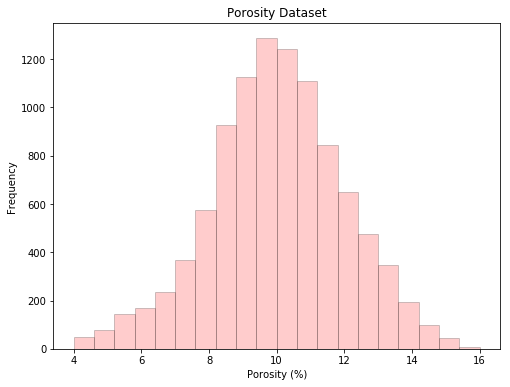

Exhastive Mean =  10.0 , Exhaustive Variance =  4.0


In [83]:
hist(sim.flatten(),vmin,vmax,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (%)",title="Porosity Dataset")
ex_mean = np.average(sim)
ex_var = np.var(sim)
print('Exhastive Mean = ',round(ex_mean,2),', Exhaustive Variance = ',round(ex_var,2))

Let's look at our 2D model with pixel plots.  The parameters below for the pixelplt function are(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap).  Array is a 2D numpy array with the realization (the output from the *GSLIB_sgsim_2d_uncond*), the xmin, xmax, ymin, ymax are the extents of the model and step is the cell size, vmin, vmax are the min and max of the feature, title, xlabel, ylabel and vlabel are the plot labels and cmap is the color map.

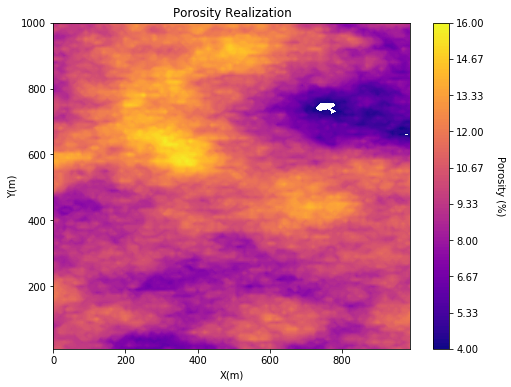

In [84]:
pixelplt(sim,xmin,xmax,ymin,ymax,cell_size,vmin,vmax,"Porosity Realization","X(m)","Y(m)","Porosity (%)",cmap)

It looks like 090 (x axis) is the direction of major continuity and 000 (y axis) is the direction of minor continuity.


#### Regularly and Irregularly Sampled Data

We have a function that extract random samples from a 2D ndarray with the parameters (array,xmin,xmax,ymin,ymax,step,nsamp,name), where array is the 2D numpy array followed by the extents and cell size and nsamp is the number of random samples and name is the name to given to the values sampled in the output DataFrame.  

In [156]:
rand_sample = random_sample(sim,xmin,xmax,ymin,ymax,cell_size,100,"Porosity")
rand_sample['Z'] = np.zeros(100)
rand_sample_mean = rand_sample[['Porosity']].mean(axis=0)

Let's visualize out new data set with and without the simulation shown. We can visualize the truth model and the samples with locpix. The parameters of locpix are (array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap). These are the same as pixelplt with the addition of the locmap parameters described below.

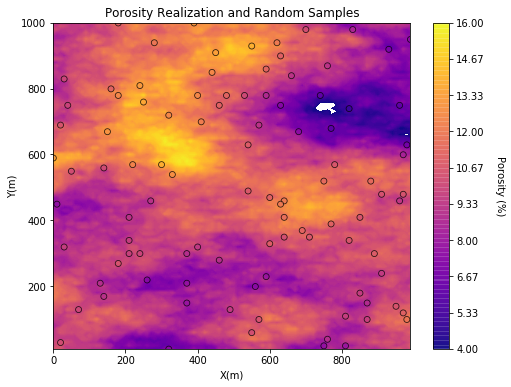

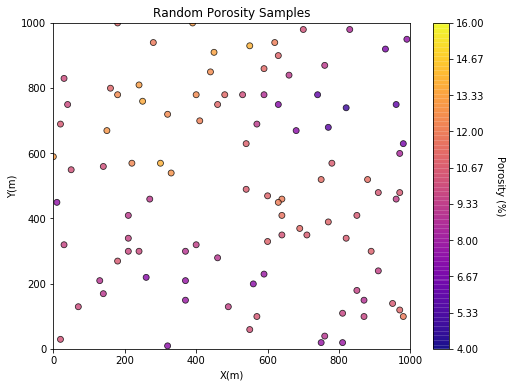

In [157]:
locpix(sim,0,1000,ymin,ymax,cell_size,vmin,vmax,rand_sample,'X','Y','Porosity','Porosity Realization and Random Samples','X(m)','Y(m)','Porosity (%)',cmap)
locmap(rand_sample,'X','Y','Porosity',xmin,xmax,ymin,ymax,vmin,vmax,'Random Porosity Samples','X(m)','Y(m)','Porosity (%)',cmap)

We also have a function to extract regularly sampled values from a 2D array and write them to a DataFrame.  Note, while regular and random sampling should provide representative samples of the truth model, it was convenient to use these functions, given the small number of random samples and the extra space around the outer samples in the regular pattern, it was anticipated that there would be some mismatch between true and sample mean and interesting location maps of declustering weights to demonstrate the declusteirng method.    

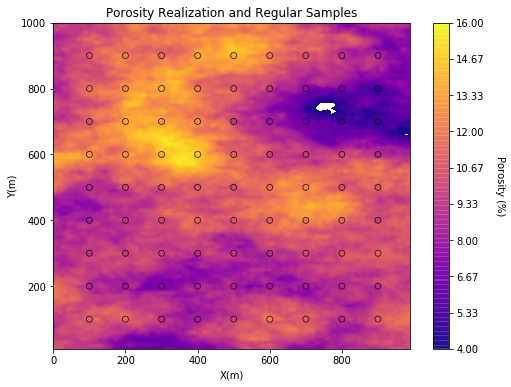

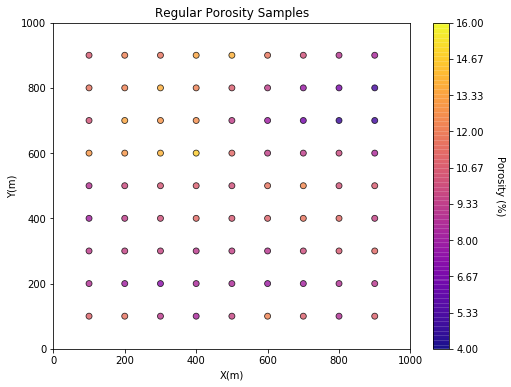

In [118]:
reg_sample = regular_sample(sim,xmin,xmax,ymin,ymax,cell_size,10,10,'Porosity')
reg_sample_mean = reg_sample[['Porosity']].mean(axis=0)
n = len(reg_sample)
reg_sample['Z'] = np.zeros(n)
locpix(sim,0,1000,ymin,ymax,cell_size,vmin,vmax,reg_sample,'X','Y','Porosity','Porosity Realization and Regular Samples','X(m)','Y(m)','Porosity (%)',cmap)
locmap(reg_sample,'X','Y','Porosity',xmin,xmax,ymin,ymax,vmin,vmax,'Regular Porosity Samples','X(m)','Y(m)','Porosity (%)',cmap)

#### Declustering with PyGSLIB

First we need to define a library with all of the parameters.  These are the same paramters used by the GSLIB algorithm declus.  We start with the regular sample case and then proceed to the random sample case. The parameters, their settings and explanations are below.

In [136]:
reg_parameters = {
       # database
        'x'      :  reg_sample.X,     # data x coordinates, array('f') with bounds (na), na is number of data points
        'y'      :  reg_sample.Y,     # data y coordinates, array('f') with bounds (na)
        'z'      :  reg_sample.Z,     # data z coordinates, array('f') with bounds (na)
        'vr'     :  reg_sample.Porosity,    # variable, array('f') with bounds (na)
       # cell size
        'anisy'  :  1.,           # Y cell anisotropy (Ysize=size*Yanis), 'f'
        'anisz'  :  1.,           # Z cell anisotropy (Zsize=size*Zanis), 'f'
        'minmax' :  0,            # 0=look for minimum declustered mean (1=max), 'i'
        'ncell'  :  100,          # number of cell sizes, 'i'
        'cmin'   :  5,            # minimum cell sizes, 'i'
        'cmax'   :  5000,         # maximum cell sizes, 'i'. Will be update to cmin if ncell == 1
        'noff'   :  8,            # number of origin offsets, 'i'. This is to avoid local minima/maxima
        'maxcel' :  100000}       # maximum number of cells, 'i'. This is to avoid large calculations, if MAXCEL<1 this check will be 

Let's try running theses parameters and checking the resulting declustered mean vs. the sample mean and the true mean.

In [150]:
declus_reg = gslib.gslib.declus(reg_parameters)
print('The true mean is ' + str(round(ex_mean,2)) + ', sample mean is ' + str(round(reg_sample_mean[0],2)) + ', and declustered mean is ' + str(round(declus_reg[1],2)))

The true mean is 10.0, sample mean is 10.13, and declustered mean is 9.93


It is also useful to visualize the resulting declustering weights at the data locations.  See the lower weights for the data at the edges as they appear to be less spatially clustered.

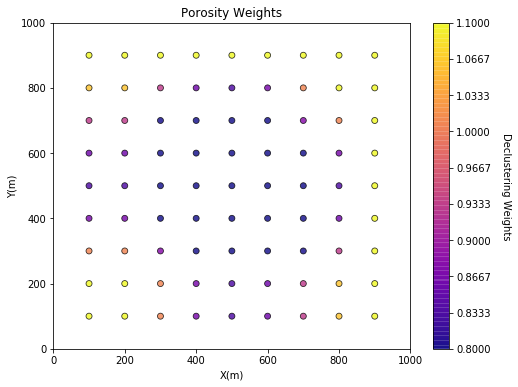

In [139]:
reg_sample['wt'] = declus_reg[0]
locmap(reg_sample,'X','Y','wt',xmin,xmax,ymin,ymax,0.8,1.1,'Porosity Weights','X(m)','Y(m)','Declustering Weights',cmap)

It is useful to also visualize the plot of the cell size vs. the declustered mean to assess the cell size selection process.  We can note that a cell size of about 800 m minimized the declustering mean.

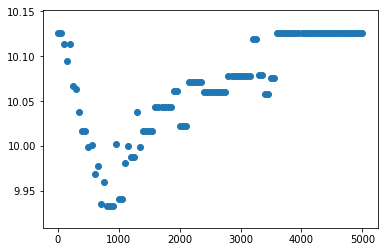

In [151]:
declus_mean_reg = declus_reg[11]
cell_size_reg = declus_reg[8]
plt.scatter(cell_size_reg,declus_mean_reg)
plt.show()

Now let's try with randomly sampled data.  As stated previously, the randomly sampled data should be representative, but may diverge from the true mean due to limited sampling.

In [154]:
rand_parameters = {
       # database
        'x'      :  rand_sample.X,     # data x coordinates, array('f') with bounds (na), na is number of data points
        'y'      :  rand_sample.Y,     # data y coordinates, array('f') with bounds (na)
        'z'      :  rand_sample.Z,     # data z coordinates, array('f') with bounds (na)
        'vr'     :  rand_sample.Porosity,    # variable, array('f') with bounds (na)
       # cell size
        'anisy'  :  1.,           # Y cell anisotropy (Ysize=size*Yanis), 'f'
        'anisz'  :  1.,           # Z cell anisotropy (Zsize=size*Zanis), 'f'
        'minmax' :  1,            # 0=look for minimum declustered mean (1=max), 'i'
        'ncell'  :  100,          # number of cell sizes, 'i'
        'cmin'   :  5,            # minimum cell sizes, 'i'
        'cmax'   :  5000,         # maximum cell sizes, 'i'. Will be update to cmin if ncell == 1
        'noff'   :  8,            # number of origin offsets, 'i'. This is to avoid local minima/maxima
        'maxcel' :  100000}       # maximum number of cells, 'i'. This is to avoid large calculations, if MAXCEL<1 this check will be 

The true mean is 10.0, sample mean is 10.08, and declustered mean is 9.83


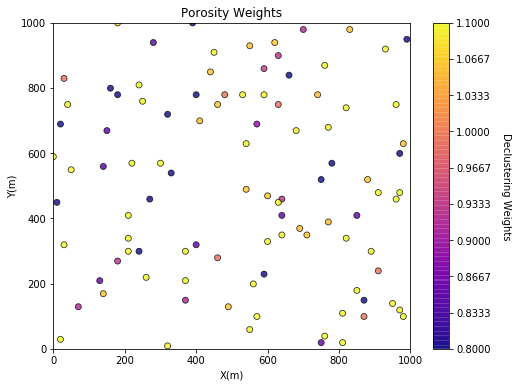

In [158]:
declus_rand = gslib.gslib.declus(rand_parameters)
rand_sample['wt'] = declus_rand[0]
print('The true mean is ' + str(round(ex_mean,2)) + ', sample mean is ' + str(round(rand_sample_mean[0],2)) + ', and declustered mean is ' + str(round(declus_rand[1],2)))
locmap(rand_sample,'X','Y','wt',xmin,xmax,ymin,ymax,0.8,1.1,'Porosity Weights','X(m)','Y(m)','Declustering Weights',cmap)

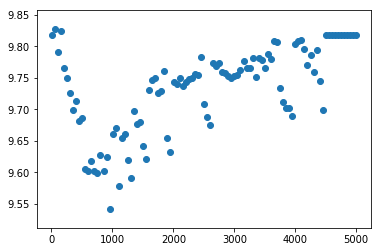

In [159]:
declus_mean = declus_rand[11]
cell_size = declus_rand[8]
plt.scatter(cell_size,declus_mean)
plt.show()


#### Comments

We cannot guarantee that declustering will always improve the estimate of the global mean, debias the sample set, but on average it should improve the representativity and reduce bias.  

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
On twitter I'm the @GeostatsGuy.
